In [1]:
'''Libraries'''
import numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, Subset
from laplace import Laplace
import matplotlib.pyplot as plt
import laplace
import pickle
import os
import random
import time
from scipy.stats import pearsonr, spearmanr

In [3]:
'''Dataset Loader for Digits dataset'''
np.random.seed(0)
torch.manual_seed(0)

# Data
digits = load_digits()
X, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

scaler = StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

Xtr_t = torch.from_numpy(Xtr)
ytr_t = torch.from_numpy(ytr)
Xte_t = torch.from_numpy(Xte)
yte_t = torch.from_numpy(yte)

train_set = TensorDataset(Xtr_t, ytr_t)
print(train_set)
n_train = len(train_set)

Task 1

In [ ]:



def cumulative_explained_ratio(val, alpha=0.9):
    """
    val: list or np.array of eigenvalues (can be positive/negative)
    alpha: target cumulative proportion (e.g., 0.9)
    
    Returns:
        ratio (float): index/p where cumulative sum first exceeds alpha
        idx (int): the actual index achieving it
    """
    val = np.array(val, dtype=float)
    # 음수 값은 curvature 설명에 기여하지 않도록 제거 (필요시 옵션화 가능)
    val = np.maximum(val, 0)
    
    if np.sum(val) == 0:
        return 0.0, 0

    sorted_vals = np.sort(val)[::-1]  # 내림차순 정렬
    cumvals = np.cumsum(sorted_vals)
    total = cumvals[-1]
    threshold = alpha * total

    idx = np.searchsorted(cumvals, threshold)
    ratio = (idx + 1) / len(val)
    return ratio, idx + 1

In [ ]:
n_repeats = 10
alpha = 0.9
results = {}

for repeat in range(n_repeats):
    print(f"\n=== Repetition {repeat+1}/{n_repeats} ===")
    
    # 💡 매 반복마다 fresh initialization
    models = get_models()

    for model in models:
        n_params = count_parameters(model)
        x_val = np.log(n_params)

        print(f"\nTraining model with {n_params} parameters (repeat {repeat+1})")

        torch.manual_seed(repeat)
        np.random.seed(repeat)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=256, shuffle=False)
        train_eval_loader = DataLoader(train_set, batch_size=256, shuffle=False)

        n_epochs_monitor = 30
        for epoch in range(n_epochs_monitor):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        # after training:
        la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='diag')
        la.fit(train_loader)
        val = la.H.cpu().numpy()

        ratio, idx = cumulative_explained_ratio(val, alpha=alpha)

        # 💾 ratio + full eigenvalues 둘 다 저장
        results.setdefault(x_val, []).append({
            'ratio': ratio,
            'eigenvalues': val
        })

with open("results_curvature_concentration.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
def _safe_extract_eigvals(obj):
    """
    Try to find an eigenvalue array (np.ndarray or list-like) inside obj.
    Return a 1D numpy array if found, else return None.
    Handles: np.ndarray, list/tuple of arrays, dict with keys like 'eigenvalues','eigvals','H','values',
    and nested structures.
    """
    # direct numpy array
    if isinstance(obj, np.ndarray):
        return obj.flatten()

    # numpy scalar or Python scalar -> not an eigenvalue array
    if isinstance(obj, (np.floating, np.integer, float, int, np.float64, np.int64)):
        return None

    # list/tuple -> try each element
    if isinstance(obj, (list, tuple)):
        for item in obj:
            arr = _safe_extract_eigvals(item)
            if arr is not None:
                return arr
        return None

    # dict -> try common keys first, then recurse over values
    if isinstance(obj, dict):
        # common possible keys that hold eigenvalues
        preferred_keys = ['eigenvalues', 'eigvals', 'eigvals_', 'H', 'values', 'vals', 'eigs', 'eigen']
        for k in preferred_keys:
            if k in obj:
                arr = _safe_extract_eigvals(obj[k])
                if arr is not None:
                    return arr

        # if none of preferred keys, recurse values (but skip scalar values)
        for v in obj.values():
            arr = _safe_extract_eigvals(v)
            if arr is not None:
                return arr
        return None

    # other types (pandas, torch tensor) - handle torch tensors
    try:
        import torch
        if isinstance(obj, torch.Tensor):
            return obj.detach().cpu().numpy().flatten()
    except Exception:
        pass

    # fallback: not recognized
    return None

def plot_cumulative_explained_ratio(results, alpha=0.9, save_path=None):
    """
    results: dict { log(n_params): [ either floats OR dicts with 'ratio' key ] }
    Draws median +/- std errorbar and saves figure.
    """
    xs = []
    medians = []
    stds = []
    for x_val, items in results.items():
        ratios = []
        # items may be list of floats or list of dicts or mixed
        for it in items:
            if isinstance(it, dict) and 'ratio' in it:
                try:
                    ratios.append(float(it['ratio']))
                except Exception:
                    pass
            elif isinstance(it, (float, int, np.floating, np.integer)):
                ratios.append(float(it))
            else:
                # maybe nested dict with ratio inside
                if isinstance(it, dict):
                    for v in it.values():
                        if isinstance(v, (float, int, np.floating, np.integer)):
                            ratios.append(float(v))
                            break
        if len(ratios) == 0:
            # skip if nothing found
            print(f"⚠️  No ratio entries found for x={x_val}, skipping.")
            continue
        xs.append(float(x_val))
        medians.append(np.median(ratios))
        stds.append(np.std(ratios))

    if len(xs) == 0:
        print("⚠️ No ratio data found in results. Nothing to plot.")
        return

    xs = np.array(xs)
    order = np.argsort(xs)
    xs = xs[order]
    medians = np.array(medians)[order]
    stds = np.array(stds)[order]

    plt.figure(figsize=(8,6))
    plt.errorbar(xs, medians, yerr=stds, fmt='o-', capsize=5, ecolor='gray', elinewidth=1.5)
    plt.xlabel("log(Number of parameters)")
    plt.ylabel(f"Cumulative explained ratio (α={alpha})")
    plt.title("Model Complexity vs. Curvature Concentration")
    plt.grid(True, alpha=0.3)

    os.makedirs("figs", exist_ok=True)
    if save_path is None:
        save_path = f"figs/cumulative_explained_ratio_{time.strftime('%Y%m%d_%H%M%S')}.png"
    else:
        # ensure directory exists
        d = os.path.dirname(save_path)
        if d:
            os.makedirs(d, exist_ok=True)

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved cumulative ratio plot → {save_path}")

def plot_logdet_vs_tracebound(results, save_path=None, clip_eps=1e-8):
    """
    results: dict { log(n_params): [ items ] }
    Each item can be:
      - a dict containing 'eigenvalues' (or 'eigvals', 'H', etc.)
      - a direct np.ndarray of eigenvalues
      - nested lists/dicts
    This computes per-trial:
      logdet = sum(log(clipped_eigvals))
      trace_bound = d * log(mean(clipped_eigvals))
    Then plots median +/- std across trials for each x (log n_params).
    """
    xs = []
    logdet_medians = []
    logdet_stds = []
    trace_medians = []
    trace_stds = []

    for x_val, items in results.items():
        # collect all eig arrays found under this x_val
        eig_lists = []
        for it in items:
            arr = _safe_extract_eigvals(it)
            if arr is None:
                continue
            # convert to numpy and flatten
            try:
                arr = np.array(arr, dtype=float).flatten()
            except Exception:
                continue
            eig_lists.append(arr)

        if len(eig_lists) == 0:
            print(f"⚠️ No eigenvalue arrays found for x={x_val}, skipping.")
            continue

        logdets = []
        tracebounds = []
        for eig in eig_lists:
            # sanitize values
            eig = eig[np.isfinite(eig)]
            if eig.size == 0:
                continue
            eig = np.clip(eig, clip_eps, None)  # avoid non-positive
            d = eig.size
            if d == 0:
                continue
            logdet = np.sum(np.log(eig))
            tracebound = d * np.log(np.sum(eig) / d)
            logdets.append(logdet)
            tracebounds.append(tracebound)

        if len(logdets) == 0:
            print(f"⚠️ After sanitization no valid eigvals for x={x_val}, skipping.")
            continue

        xs.append(float(x_val))
        logdet_medians.append(np.median(logdets))
        logdet_stds.append(np.std(logdets))
        trace_medians.append(np.median(tracebounds))
        trace_stds.append(np.std(tracebounds))

    if len(xs) == 0:
        print("⚠️ No valid data to plot for logdet vs tracebound.")
        return

    xs = np.array(xs)
    order = np.argsort(xs)
    xs = xs[order]
    logdet_medians = np.array(logdet_medians)[order]
    logdet_stds = np.array(logdet_stds)[order]
    trace_medians = np.array(trace_medians)[order]
    trace_stds = np.array(trace_stds)[order]

    plt.figure(figsize=(8,6))
    plt.errorbar(xs, logdet_medians, yerr=logdet_stds, fmt='o-', label='log|H| (∑ log λ_i)')
    plt.errorbar(xs, trace_medians, yerr=trace_stds, fmt='s--', label='trace bound (d·log(tr/d))')
    plt.xlabel("log(Number of parameters)")
    plt.ylabel("Value")
    plt.title("Log-determinant vs. Trace Bound (Curvature Scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    os.makedirs("figs", exist_ok=True)
    if save_path is None:
        save_path = f"figs/logdet_vs_tracebound_{time.strftime('%Y%m%d_%H%M%S')}.png"
    else:
        d = os.path.dirname(save_path)
        if d:
            os.makedirs(d, exist_ok=True)

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    print(f"✅ Saved logdet/trace plot → {save_path}")

with open("results_curvature_concentration.pkl", "rb") as f:
    results = pickle.load(f)
plot_logdet_vs_tracebound(results, save_path='logdet_vs_tracebound.png')
plot_cumulative_explained_ratio(results, alpha=0.9, save_path='cumulative_explained_ratio.png')

✅ Saved logdet/trace plot → logdet_vs_tracebound.png
✅ Saved cumulative ratio plot → cumulative_explained_ratio.png


Task 2

In [103]:
np.random.seed(0)
torch.manual_seed(0)

# Data 준비 (기존 Xtr_t, ytr_t 사용)
digits = load_digits()
x, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
Xtr, Xte, ytr, yte = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)
scaler = StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

Xtr_t = torch.from_numpy(Xtr)          # (N_train, D)
ytr_t = torch.from_numpy(ytr).long()   # (N_train,)
Xte_t = torch.from_numpy(Xte)
yte_t = torch.from_numpy(yte)

num_pretrain = 30
indices = list(range(len(Xtr_t)))
random.shuffle(indices)
labeled_indices = indices[:num_pretrain]       # 실제 dataset 인덱스들
unlabeled_indices = indices[num_pretrain:]

# 기본 전체 텐서데이터셋 하나 생성
full_train_dataset = TensorDataset(Xtr_t, ytr_t)

# Subset으로 라벨/언라벨드 관리 (TensorDataset에 직접 numpy 넣지 않음)
train_set_Labeled = Subset(full_train_dataset, labeled_indices)
train_set_Unlabeled = Subset(full_train_dataset, unlabeled_indices)
test_set = TensorDataset(Xte_t, yte_t)


In [ ]:

def initialize_model_weights(model, init_type='xavier'):
    """
    모델 가중치를 초기화합니다.
    init_type: 'xavier', 'kaiming', 'normal', 'uniform'
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if init_type == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif init_type == 'kaiming':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif init_type == 'normal':
                nn.init.normal_(m.weight, mean=0, std=0.01)
            elif init_type == 'uniform':
                nn.init.uniform_(m.weight, -0.1, 0.1)
            
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
    
    return model

def fast_jacobian(model, x):
    model.zero_grad()
    # ensure batch dimension
    if x.ndim == 1:
        x = x.unsqueeze(0)  # (1, input_dim)
    b = x.shape[0]

    params = [p for p in model.parameters() if p.requires_grad]
    # precompute param sizes to flatten consistently
    param_numels = [p.numel() for p in params]

    J_batch = []
    for i in range(b):
        xi = x[i : i + 1]  # keep batch dim for forward
        yi = model(xi)  # (1, d_out)
        d_out = yi.shape[-1]

        # compute grads for this sample: result (d_out, n_params)
        J_i_rows = []
        for k in range(d_out):
            grads = torch.autograd.grad(yi[0, k], params, retain_graph=True)
            grad_flat = torch.cat([g.reshape(-1) for g in grads])
            J_i_rows.append(grad_flat)
        J_i = torch.stack(J_i_rows, dim=0)  # (d_out, n_params)
        J_batch.append(J_i)

    J_batch = torch.stack(J_batch, dim=0)  # (b, d_out, n_params)
    return J_batch

def compute_outcome_hessian_from_model(model, inputs):
    # inputs: (d,) or (b, d)
    if inputs.ndim == 1:
        inputs = inputs.unsqueeze(0)
    z = model(inputs)  # (b, d_out)
    p = torch.softmax(z, dim=-1)  # (b, d_out)
    # diag_embed builds (b, d_out, d_out)
    H = torch.diag_embed(p) - p.unsqueeze(2) * p.unsqueeze(1)  # (b, d_out, d_out)
    return H

def symmetric_matrix_sqrt(A, eps=1e-12):
    """
    A: (n,n) or (batch, n, n)
    returns: A_sqrt with same shape
    """
    single = (A.dim() == 2)
    if single:
        A = A.unsqueeze(0)
    w, v = torch.linalg.eigh(A)
    w_clamped = torch.clamp(w, min=eps)
    w_sqrt = torch.sqrt(w_clamped)
    A_sqrt = (v * w_sqrt.unsqueeze(-2)) @ v.transpose(-2, -1)
    if single:
        return A_sqrt[0]
    return A_sqrt

def low_rank_updated_part(model, x, return_batch: bool = False):
    """
    Returns:
      - if return_batch=True: U_batch of shape (b, n_params, d_out)
      - else: U_all of shape (n_params, b * d_out)  (backward-compatible)
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    H = compute_outcome_hessian_from_model(model, x)    # (b, d_out, d_out)
    J_batch = fast_jacobian(model, x)                   # (b, d_out, n_params)
    H_sqrt = symmetric_matrix_sqrt(H)                   # (b, d_out, d_out)

    # J_batch: (b, d_out, n_params) -> transpose -> (b, n_params, d_out)
    Jt = J_batch.transpose(1, 2)
    U_batch = torch.matmul(Jt, H_sqrt)                  # (b, n_params, d_out)

    if return_batch:
        return U_batch
    b, n_params, d_out = U_batch.shape
    U_all = U_batch.permute(1, 0, 2).reshape(n_params, b * d_out)
    return U_all

def DoptScore_per_sample(model, x, Hessian, eps=1e-10):
    """
    Compute D-opt score per input sample.
    - x: (input_dim,) or (b, input_dim)
    - Hessian: torch tensor (n_params,) (diagonal)
    Returns: torch tensor shape (b,) with per-sample log-determinant scores
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    U_batch = low_rank_updated_part(model, x, return_batch=True)   # (b, n_params, d_out)
    Hinv = 1.0 / (Hessian + eps)                                   # (n_params,)

    scores = []
    for i in range(U_batch.shape[0]):
        U_i = U_batch[i]                    # (n_params, d_out)
        C = Hinv.unsqueeze(1) * U_i         # (n_params, d_out)
        A = torch.eye(U_i.shape[1], device=U_i.device) + (U_i.T @ C)  # (d_out, d_out)
        # use slogdet for stability
        sign, ld = torch.linalg.slogdet(A)
        # if numeric issue (sign <=0) return nan for that sample
        scores.append(ld if sign > 0 else torch.tensor(float('nan'), device=A.device))
    return torch.stack(scores)  # (b,)

def AoptScore_per_sample(model, x, Hessian, eps=1e-10):
    """
    Compute A-opt reduction per input sample.
    Returns: torch tensor shape (b,) with per-sample Delta values.
    """
    if x.ndim == 1:
        x = x.unsqueeze(0)
    U_batch = low_rank_updated_part(model, x, return_batch=True)   # (b, n_params, d_out)
    Hinv = 1.0 / (Hessian + eps)                                   # (n_params,)

    deltas = []
    for i in range(U_batch.shape[0]):
        U_i = U_batch[i]                    # (n_params, d_out)
        C = Hinv.unsqueeze(1) * U_i         # (n_params, d_out)
        A = torch.eye(U_i.shape[1], device=U_i.device) + (U_i.T @ C)  # (d_out, d_out)
        A = A + eps * torch.eye(A.shape[0], device=A.device)
        S = C.T @ C                          # (d_out, d_out)
        X = torch.linalg.solve(A, S)         # (d_out, d_out)
        deltas.append(torch.trace(X))
    return torch.stack(deltas)  # (b,)

def train_model(model, train_set_Labeled, criterion, optimizer, n_epochs=10):
    n_epochs_monitor = n_epochs
    for epoch in range(n_epochs_monitor):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_set_Labeled:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return model

def return_hessian_eigenvalues(model, train_set_Labeled):
    la = Laplace(model, 'classification', subset_of_weights='all', hessian_structure='diag')
    train_loader = DataLoader(train_set_Labeled, batch_size=32, shuffle=True)
    la.fit(train_loader)
    val = la.H
    return val

def selection_AL_scores(model, unlabeled_set, Hessian, score_type='Aopt', top_k=10):
    """
    Select top_k samples from unlabeled_set based on AL scores.
    score_type: 'Aopt' or 'Dopt'
    Returns: indices of selected samples in unlabeled_set
    """
    if score_type == 'Aopt':
        scores = AoptScore_per_sample(model, unlabeled_set[:][0], Hessian)
    elif score_type == 'Dopt':
        scores = DoptScore_per_sample(model, unlabeled_set[:][0], Hessian)
    else:
        raise ValueError("score_type must be 'Aopt' or 'Dopt'")

    # Get top_k indices
    topk_indices = torch.topk(scores, k=top_k).indices
    return topk_indices.tolist()

def extract_samples_from_unlabeled(unlabeled_set, selected_indices):
    """
    Extract samples at selected_indices from unlabeled_set.
    Returns: list of (input, label) tuples.
    """
    samples = [unlabeled_set[i] for i in selected_indices]
    return samples

def delete_samples_from_unlabeled(unlabeled_set, selected_indices):
    """
    Remove samples at selected_indices from unlabeled_set.
    Returns: new Subset of unlabeled_set without selected samples.
    """
    all_indices = list(range(len(unlabeled_set)))
    remaining_indices = [i for j, i in enumerate(all_indices) if j not in selected_indices]
    new_unlabeled_set = Subset(unlabeled_set.dataset, [unlabeled_set.indices[i] for i in remaining_indices])
    return new_unlabeled_set

def add_samples_to_labeled(labeled_set, unlabeled_set, selected_indices):
    """
    Add samples at selected_indices from unlabeled_set to labeled_set.
    Returns: new Subset of labeled_set with added samples.
    """
    new_indices = labeled_set.indices + [unlabeled_set.indices[i] for i in selected_indices]
    new_labeled_set = Subset(labeled_set.dataset, new_indices)
    return new_labeled_set

def add_and_extract_and_delete_samples(labeled_set, unlabeled_set, selected_indices):
    new_labeled_set = add_samples_to_labeled(labeled_set, unlabeled_set, selected_indices)
    extracted_samples = extract_samples_from_unlabeled(unlabeled_set, selected_indices)
    new_unlabeled_set = delete_samples_from_unlabeled(unlabeled_set, selected_indices)
    return new_labeled_set, new_unlabeled_set, extracted_samples

def AL_finetune_model(model, AL_train_set_Labeled, criterion, optimizer, n_epochs=10):
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in AL_train_set_Labeled:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

def evaluate(loader, model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return correct / total

def count_parameters(model, only_trainable=False):
    """
    모델의 파라미터 개수를 반환합니다.
    only_trainable=True이면 requires_grad=True인 파라미터만 셉니다.
    """
    params = (p for p in model.parameters() if (not only_trainable) or p.requires_grad)
    return sum(p.numel() for p in params)

def get_models():
    models = []

    # 1. 가장 단순한 모델
    models.append(nn.Linear(64, 10))

    # 2. 파라미터 2배: Linear + Linear
    models.append(nn.Sequential(
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ))

    # 3. 더 깊게: Linear + Linear + Linear
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ))

    # 4. 더 깊고 넓게
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 5. BatchNorm 추가
    models.append(nn.Sequential(
        nn.Linear(64, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ))

    # 6. Dropout 추가
    models.append(nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 7. 더 깊게, 더 넓게
    models.append(nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 8. 더 많은 레이어와 BatchNorm, Dropout
    models.append(nn.Sequential(
        nn.Linear(64, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 9. 더 깊고 넓게, 활성화 다양화
    models.append(nn.Sequential(
        nn.Linear(64, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.Tanh(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    # 10. 가장 큰 모델
    models.append(nn.Sequential(
        nn.Linear(64, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ))

    return models


models = get_models()
model = models[0]
model = initialize_model_weights(model, init_type='normal')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

Hessian_data_list = []
model = train_model(model, train_set_Labeled, criterion, optimizer, n_epochs=10)


n_AL_iterations = 100

for iter in range(n_AL_iterations):
    Hessian = return_hessian_eigenvalues(model, train_set_Labeled)
    selected_indices = selection_AL_scores(model, train_set_Unlabeled, Hessian, score_type='Aopt', top_k=1)
    train_set_Labeled, train_set_Unlabeled, extracted_samples = add_and_extract_and_delete_samples(train_set_Labeled, train_set_Unlabeled, selected_indices)
    model = AL_finetune_model(model, extracted_samples, criterion, optimizer, n_epochs=10)
    test_acc = evaluate(test_loader, model)
    Hessian_data_list.append(Hessian.cpu().numpy())
    if iter % 10 == 0:
        print(f"AL Iteration {iter}/{n_AL_iterations}, Test Accuracy: {test_acc:.4f}")


AL Iteration 0/100, Test Accuracy: 0.7289
AL Iteration 10/100, Test Accuracy: 0.7067
AL Iteration 20/100, Test Accuracy: 0.6844
AL Iteration 30/100, Test Accuracy: 0.7133
AL Iteration 40/100, Test Accuracy: 0.6911
AL Iteration 50/100, Test Accuracy: 0.8044
AL Iteration 60/100, Test Accuracy: 0.8000
AL Iteration 70/100, Test Accuracy: 0.8267
AL Iteration 80/100, Test Accuracy: 0.8356
AL Iteration 90/100, Test Accuracy: 0.8667


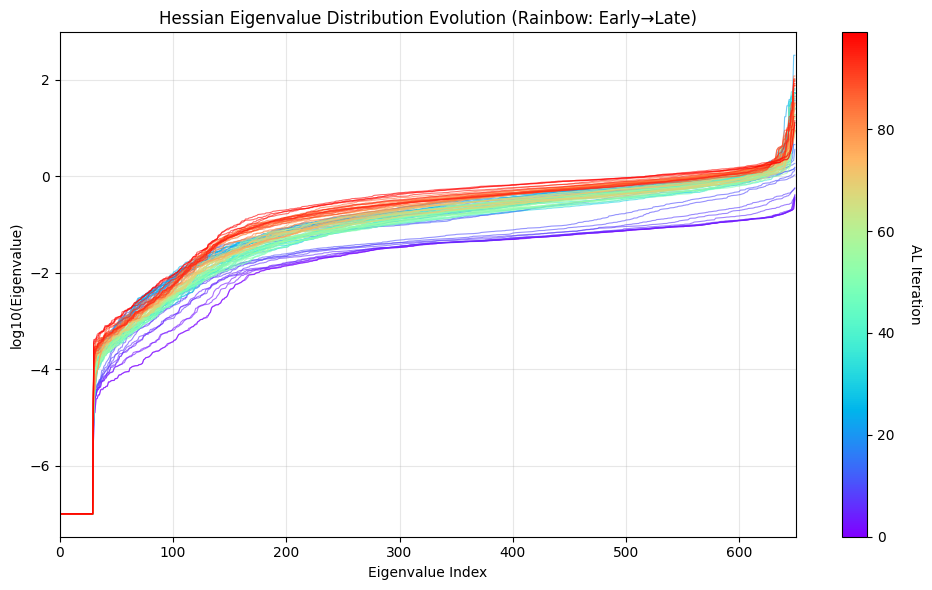

In [102]:
import matplotlib.cm as cm

# Rainbow colormap으로 시간에 따라 색상 변화
n_iterations = len(Hessian_data_list)
colors = cm.rainbow(np.linspace(0, 1, n_iterations))

plt.figure(figsize=(10, 6))
for i in range(n_iterations):
    sorted_eigvals = np.sort(Hessian_data_list[i])
    plt.plot(np.log10(sorted_eigvals + 1e-7), color=colors[i], alpha=0.6, linewidth=0.8)

plt.xlabel('Eigenvalue Index')
plt.ylabel('log10(Eigenvalue)')
plt.xlim(0, len(Hessian_data_list[0]))
plt.title('Hessian Eigenvalue Distribution Evolution (Rainbow: Early→Late)')
plt.grid(True, alpha=0.3)

# Colorbar 추가
sm = cm.ScalarMappable(cmap='rainbow', norm=plt.Normalize(vmin=0, vmax=n_iterations-1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('AL Iteration', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

In [46]:
train_set_Labeled[-1]

(tensor([ 0.0000, -0.3320, -1.1011, -1.8447,  0.4978,  1.4467, -0.0994, -0.1171,
         -0.0630, -0.6279, -1.3843,  0.5138,  0.3635,  0.2738,  0.6156, -0.1218,
         -0.0386,  0.1018,  0.5356, -0.5069, -1.1432,  0.0208,  1.3295, -0.1109,
         -0.0273,  0.1631,  0.9503,  0.0244, -1.2871,  1.2695, -0.3542, -0.0472,
          0.0000, -0.6679, -0.8961,  0.1427,  0.9552,  0.7387, -0.8165,  0.0000,
         -0.0682, -0.5280, -1.0565, -1.1332,  0.6818,  1.0279,  0.1246, -0.0849,
         -0.0380, -0.4006, -1.3332, -1.4548,  0.4971,  0.0407, -0.1551, -0.1970,
         -0.0273, -0.2976, -1.0942, -2.3251,  0.8544,  1.2141, -0.5075, -0.1907]),
 tensor(8))